In [1]:
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import torch
print(torch.__version__)
print(torch.version.cuda)


2.4.1+cu118
11.8


In [3]:
import torch
print(torch.cuda.is_available())

True


In [4]:
# Define the custom dataset to load and preprocess images
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, base_dir, subfolders, transform=None):
        self.base_dir = base_dir
        self.subfolders = subfolders
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        for subfolder in subfolders:
            folder_path = os.path.join(base_dir, subfolder)
            label = subfolder

            for img_name in os.listdir(folder_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(folder_path, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(label)
        
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        return image, label

# Define the base directory and subfolders
base_dir = r'DIAT-uSAT_dataset'
subfolders = [
    r"3_long_blade_rotor", 
    r"3_short_blade_rotor", 
    r"Bird", 
    r"Bird+mini-helicopter", 
    r"drone", 
    r"rc_plane", 
]

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

In [5]:
# Load dataset
dataset = CustomImageDataset(base_dir, subfolders, transform=transform)

In [6]:
torch.manual_seed(42) 
indices = torch.randperm(len(dataset)) 
shuffled_dataset = torch.utils.data.Subset(dataset, indices)

In [7]:
train_size = int(0.85 * len(shuffled_dataset))
val_size = int(0.05 * len(shuffled_dataset))
test_size = len(shuffled_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(shuffled_dataset, [train_size, val_size, test_size])

In [8]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.5005665].


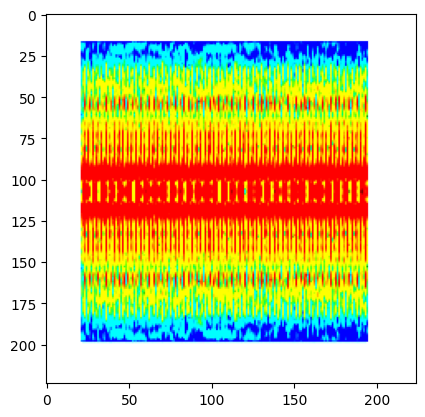

In [9]:
# Visualize one sample
sample_image, sample_label = next(iter(train_loader))
sample_image = sample_image[0] 
sample_image = sample_image.permute(1, 2, 0)  

plt.imshow(sample_image)
plt.show()

In [10]:
# Model definitions using VGG16 and VGG19
class CustomVGG(nn.Module):
    def __init__(self, base_model, num_classes):
        super(CustomVGG, self).__init__()
        self.features = base_model.features
        self.avgpool = base_model.avgpool
        self.classifier = nn.Sequential(
            nn.Linear(base_model.classifier[0].in_features, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Initialize models
vgg16_base = models.vgg16(pretrained=True)
for param in vgg16_base.parameters():
    param.requires_grad = False
model_vgg16 = CustomVGG(vgg16_base, num_classes=6)

vgg19_base = models.vgg19(pretrained=True)
for param in vgg19_base.parameters():
    param.requires_grad = False
model_vgg19 = CustomVGG(vgg19_base, num_classes=6)

c:\Users\Shravya H Jain\Desktop\ML+AI\Micro-Doppler-Based-Target-Classification\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Shravya H Jain\Desktop\ML+AI\Micro-Doppler-Based-Target-Classification\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Shravya H Jain\Desktop\ML+AI\Micro-Doppler-Based-Target-Classification\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed 

In [11]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vgg16.to(device)
model_vgg19.to(device)

CustomVGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1)

In [12]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_vgg16 = optim.Adam(model_vgg16.classifier.parameters(), lr=0.0001)
optimizer_vgg19 = optim.Adam(model_vgg19.classifier.parameters(), lr=0.0001)

In [13]:
# Learning rate scheduler
scheduler_vgg16 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_vgg16, mode='min', factor=0.5, patience=2, min_lr=1e-7, verbose=True)
scheduler_vgg19 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_vgg19, mode='min', factor=0.5, patience=2, min_lr=1e-7, verbose=True)

c:\Users\Shravya H Jain\Desktop\ML+AI\Micro-Doppler-Based-Target-Classification\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [14]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15):
    model.train()
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_corrects = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
        
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * images.size(0)
                val_corrects += torch.sum(preds == labels.data)
        
        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
        
        scheduler.step(val_loss)
        
        # Save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"best_model_{model.__class__.__name__}.pt")
        
        model.train()

In [15]:
# Train VGG16 model
train_model(model_vgg16, train_loader, val_loader, criterion, optimizer_vgg16, scheduler_vgg16)

Epoch [1/15], Loss: 0.4371, Accuracy: 0.8500
Validation Loss: 0.1911, Accuracy: 0.9215
Epoch [2/15], Loss: 0.1875, Accuracy: 0.9403
Validation Loss: 0.0920, Accuracy: 0.9793
Epoch [3/15], Loss: 0.1379, Accuracy: 0.9573
Validation Loss: 0.0655, Accuracy: 0.9917
Epoch [4/15], Loss: 0.1055, Accuracy: 0.9680
Validation Loss: 0.0604, Accuracy: 0.9876
Epoch [5/15], Loss: 0.0898, Accuracy: 0.9697
Validation Loss: 0.0397, Accuracy: 0.9917
Epoch [6/15], Loss: 0.0788, Accuracy: 0.9731
Validation Loss: 0.0549, Accuracy: 0.9876
Epoch [7/15], Loss: 0.0693, Accuracy: 0.9769
Validation Loss: 0.0351, Accuracy: 0.9917
Epoch [8/15], Loss: 0.0605, Accuracy: 0.9794
Validation Loss: 0.0790, Accuracy: 0.9793
Epoch [9/15], Loss: 0.0496, Accuracy: 0.9847
Validation Loss: 0.0285, Accuracy: 0.9917
Epoch [10/15], Loss: 0.0481, Accuracy: 0.9825
Validation Loss: 0.0335, Accuracy: 0.9876
Epoch [11/15], Loss: 0.0474, Accuracy: 0.9830
Validation Loss: 0.0355, Accuracy: 0.9876
Epoch [12/15], Loss: 0.0384, Accuracy: 0.

In [16]:
train_model(model_vgg19, train_loader, val_loader, criterion, optimizer_vgg19, scheduler_vgg19)

Epoch [1/15], Loss: 0.5034, Accuracy: 0.8275
Validation Loss: 0.1749, Accuracy: 0.9545
Epoch [2/15], Loss: 0.2482, Accuracy: 0.9170
Validation Loss: 0.1124, Accuracy: 0.9835
Epoch [3/15], Loss: 0.1816, Accuracy: 0.9386
Validation Loss: 0.1005, Accuracy: 0.9752
Epoch [4/15], Loss: 0.1498, Accuracy: 0.9517
Validation Loss: 0.0804, Accuracy: 0.9752
Epoch [5/15], Loss: 0.1330, Accuracy: 0.9510
Validation Loss: 0.0880, Accuracy: 0.9669
Epoch [6/15], Loss: 0.1140, Accuracy: 0.9612
Validation Loss: 0.0609, Accuracy: 0.9835
Epoch [7/15], Loss: 0.0960, Accuracy: 0.9704
Validation Loss: 0.0526, Accuracy: 0.9917
Epoch [8/15], Loss: 0.0876, Accuracy: 0.9697
Validation Loss: 0.0753, Accuracy: 0.9835
Epoch [9/15], Loss: 0.0776, Accuracy: 0.9748
Validation Loss: 0.0478, Accuracy: 0.9752
Epoch [10/15], Loss: 0.0714, Accuracy: 0.9762
Validation Loss: 0.0513, Accuracy: 0.9876
Epoch [11/15], Loss: 0.0635, Accuracy: 0.9777
Validation Loss: 0.0475, Accuracy: 0.9835
Epoch [12/15], Loss: 0.0656, Accuracy: 0.

In [20]:
import torch
from sklearn.metrics import classification_report
def test_model(model, test_loader, criterion, label_encoder):
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    test_acc = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation for inference
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            test_acc += torch.sum(preds == labels.data).item()
            
            # Collect all predictions and labels for the classification report
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    test_acc = test_acc / len(test_loader.dataset)

    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

    # Classification Report
    report = classification_report(all_labels, all_preds, target_names=label_encoder.classes_)
    print("Classification Report:")
    print(report)


In [21]:
label_encoder = dataset.label_encoder  # Extract the label encoder from your dataset
test_model(model_vgg16, test_loader, criterion, label_encoder)

Test Loss: 0.0391, Accuracy: 0.9815
Classification Report:
                      precision    recall  f1-score   support

  3_long_blade_rotor       0.97      0.99      0.98        72
 3_short_blade_rotor       0.99      0.95      0.97        85
                Bird       1.00      1.00      1.00        76
Bird+mini-helicopter       0.96      1.00      0.98        78
               drone       1.00      1.00      1.00        85
            rc_plane       0.97      0.96      0.96        90

            accuracy                           0.98       486
           macro avg       0.98      0.98      0.98       486
        weighted avg       0.98      0.98      0.98       486



In [22]:
test_model(model_vgg19, test_loader, criterion, label_encoder)

Test Loss: 0.0636, Accuracy: 0.9753
Classification Report:
                      precision    recall  f1-score   support

  3_long_blade_rotor       0.93      0.97      0.95        72
 3_short_blade_rotor       1.00      0.94      0.97        85
                Bird       1.00      1.00      1.00        76
Bird+mini-helicopter       1.00      0.95      0.97        78
               drone       1.00      1.00      1.00        85
            rc_plane       0.93      0.99      0.96        90

            accuracy                           0.98       486
           macro avg       0.98      0.98      0.98       486
        weighted avg       0.98      0.98      0.98       486



In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(CustomCNN, self).__init__()
        # 1st Convolutional Block
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 2nd Convolutional Block
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 3rd Convolutional Block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 4th Convolutional Block
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(128, 512)
        self.fc2 = nn.Linear(512, 6)  # Output for 6 classes

        # Dropout for Regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # 1st Convolutional Block
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        
        # 2nd Convolutional Block
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        
        # 3rd Convolutional Block
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        # 4th Convolutional Block
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))

        # Global Average Pooling
        x = self.global_avg_pool(x)
        
        # Flatten the output
        x = torch.flatten(x, 1)
        
        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x


In [24]:
# Initialize Deeper CNN model
model_deepercnn = CustomCNN(num_classes=6)
model_deepercnn.to(device)

CustomCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [25]:
# Loss and optimizer for Deeper CNN
optimizer_deepercnn = optim.Adam(model_deepercnn.parameters(), lr=0.0001)
scheduler_deepercnn = optim.lr_scheduler.ReduceLROnPlateau(optimizer_deepercnn, mode='min', factor=0.5, patience=2, min_lr=1e-7, verbose=True)

c:\Users\Shravya H Jain\Desktop\ML+AI\Micro-Doppler-Based-Target-Classification\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [27]:
# Train Deeper CNN model
train_model(model_deepercnn, train_loader, val_loader, criterion, optimizer_deepercnn, scheduler_deepercnn, num_epochs=20)

Epoch [1/20], Loss: 0.4767, Accuracy: 0.8350
Validation Loss: 0.2733, Accuracy: 0.9174
Epoch [2/20], Loss: 0.3879, Accuracy: 0.8731
Validation Loss: 0.1739, Accuracy: 0.9463
Epoch [3/20], Loss: 0.3171, Accuracy: 0.9008
Validation Loss: 0.1695, Accuracy: 0.9628
Epoch [4/20], Loss: 0.2926, Accuracy: 0.9049
Validation Loss: 0.2037, Accuracy: 0.9463
Epoch [5/20], Loss: 0.2464, Accuracy: 0.9207
Validation Loss: 0.2183, Accuracy: 0.9339
Epoch [6/20], Loss: 0.2189, Accuracy: 0.9304
Validation Loss: 0.1217, Accuracy: 0.9587
Epoch [7/20], Loss: 0.2090, Accuracy: 0.9323
Validation Loss: 0.0805, Accuracy: 0.9835
Epoch [8/20], Loss: 0.1949, Accuracy: 0.9405
Validation Loss: 0.0577, Accuracy: 0.9876
Epoch [9/20], Loss: 0.1788, Accuracy: 0.9439
Validation Loss: 0.0700, Accuracy: 0.9793
Epoch [10/20], Loss: 0.1504, Accuracy: 0.9554
Validation Loss: 0.0382, Accuracy: 1.0000
Epoch [11/20], Loss: 0.1449, Accuracy: 0.9537
Validation Loss: 0.1045, Accuracy: 0.9628
Epoch [12/20], Loss: 0.1490, Accuracy: 0.

In [28]:
# Test custom cnn
test_model(model_deepercnn, test_loader, criterion, label_encoder)

Test Loss: 0.0861, Accuracy: 0.9650
Classification Report:
                      precision    recall  f1-score   support

  3_long_blade_rotor       0.99      0.92      0.95        72
 3_short_blade_rotor       0.96      0.91      0.93        85
                Bird       1.00      1.00      1.00        76
Bird+mini-helicopter       0.99      0.96      0.97        78
               drone       1.00      1.00      1.00        85
            rc_plane       0.88      1.00      0.94        90

            accuracy                           0.97       486
           macro avg       0.97      0.96      0.97       486
        weighted avg       0.97      0.97      0.97       486



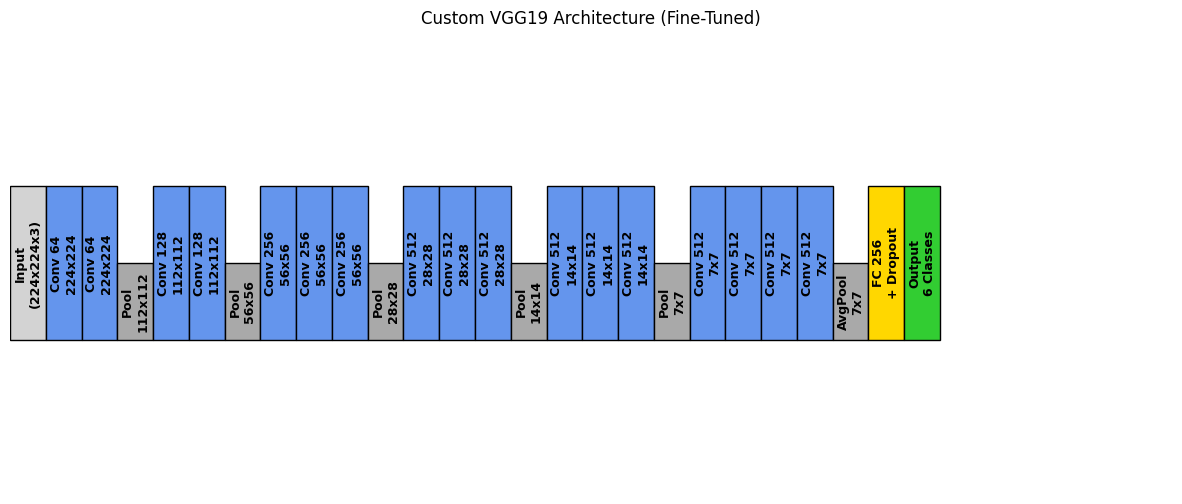

In [29]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


fig, ax = plt.subplots(figsize=(15, 6))


colors = {
    'input': '#d3d3d3',  # Light gray for Input Layer
    'conv': '#6495ed',   # Blue for Convolution + ReLU
    'pool': '#a9a9a9',   # Dark gray for Max Pooling
    'dense': '#ffd700',  # Gold for Fully Connected + ReLU
    'output': '#32cd32'  # Lime for Output (softmax)
}

def draw_block(ax, x, y, width, height, label, color):
    rect = patches.Rectangle((x, y), width, height, edgecolor='black', facecolor=color)
    ax.add_patch(rect)

    ax.text(x + width / 2, y + height / 2, label, color='black',
            ha='center', va='center', fontsize=9, weight="bold", rotation=90)

block_width = 0.4


draw_block(ax, 0, 1, block_width, 1, 'Input\n(224x224x3)', colors['input'])

# Conv + ReLU Layers
conv_layers = [
    ('Conv 64\n224x224', block_width), ('Conv 64\n224x224', block_width), ('Pool\n112x112', block_width),
    ('Conv 128\n112x112', block_width), ('Conv 128\n112x112', block_width), ('Pool\n56x56', block_width),
    ('Conv 256\n56x56', block_width), ('Conv 256\n56x56', block_width), ('Conv 256\n56x56', block_width), ('Pool\n28x28', block_width),
    ('Conv 512\n28x28', block_width), ('Conv 512\n28x28', block_width), ('Conv 512\n28x28', block_width), ('Pool\n14x14', block_width),
    ('Conv 512\n14x14', block_width), ('Conv 512\n14x14', block_width), ('Conv 512\n14x14', block_width), ('Pool\n7x7', block_width),
    ('Conv 512\n7x7', block_width), ('Conv 512\n7x7', block_width), ('Conv 512\n7x7', block_width), ('Conv 512\n7x7', block_width)  # Additional layers
]

x_offset = block_width
for layer, width in conv_layers:
    if 'Conv' in layer:
        draw_block(ax, x_offset, 1, width, 1, layer, colors['conv'])
    else:  
        draw_block(ax, x_offset, 1, width, 0.5, layer, colors['pool'])
    x_offset += width

# Adaptive Average Pooling
draw_block(ax, x_offset, 1, block_width, 0.5, 'AvgPool\n7x7', colors['pool'])
x_offset += block_width

# Fully Connected + Dropout + ReLU Layers
draw_block(ax, x_offset, 1, block_width, 1, 'FC 256\n+ Dropout', colors['dense'])
x_offset += block_width

# Output Layer
draw_block(ax, x_offset, 1, block_width, 1, 'Output\n6 Classes', colors['output'])


ax.set_xlim(0, x_offset + 3)
ax.set_ylim(0, 3)
ax.axis('off')


plt.title('Custom VGG19 Architecture (Fine-Tuned)')
plt.show()

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np


In [19]:
class ACGANGenerator(nn.Module):
    def __init__(self, latent_dim, num_classes, img_channels):
        super(ACGANGenerator, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.img_channels = img_channels
        
        # Input: latent_dim + num_classes
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128),
            nn.BatchNorm1d(128, 0.8),
            nn.ReLU(inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.ReLU(inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512, 0.8),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024, 0.8),
            nn.ReLU(inplace=True),
            nn.Linear(1024, img_channels * 64 * 64),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate noise and labels
        label_input = self.label_emb(labels)
        gen_input = torch.cat((noise, label_input), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), self.img_channels, 64, 64)
        return img


In [20]:
class ACGANDiscriminator(nn.Module):
    def __init__(self, img_channels, num_classes):
        super(ACGANDiscriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(img_channels * 64 * 64, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(128, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(128, num_classes), nn.Softmax(dim=1))

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        features = self.model(img_flat)
        
        # Discriminator output: real/fake
        validity = self.adv_layer(features)
        
        # Auxiliary output: class labels
        label = self.aux_layer(features)

        return validity, label


In [22]:
# Hyperparameters
latent_dim = 100
num_classes = 6
img_channels = 3
learning_rate = 0.0002
batch_size = 20

# Initialize generator and discriminator
generator = ACGANGenerator(latent_dim, num_classes, img_channels)
discriminator = ACGANDiscriminator(img_channels, num_classes)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# Loss functions
adversarial_loss = nn.BCELoss()
auxiliary_loss = nn.CrossEntropyLoss()


In [23]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize images to [-1, 1]
])

# Load dataset using ImageFolder
base_dir = 'DIAT-uSAT_dataset'  # Make sure this path is correct
dataset = ImageFolder(base_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=20, shuffle=True)


In [24]:
num_epochs = 20
best_g_loss = float('inf')  # Initialize best generator loss as infinity

for epoch in range(num_epochs):
    total_g_loss = 0.0
    total_d_loss = 0.0
    num_batches = len(dataloader)
    
    for i, (imgs, labels) in enumerate(dataloader):
        
        batch_size = imgs.size(0)
        valid = torch.ones((batch_size, 1), requires_grad=False)
        fake = torch.zeros((batch_size, 1), requires_grad=False)

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        z = torch.randn(batch_size, latent_dim)
        gen_labels = torch.randint(0, num_classes, (batch_size,))

        gen_imgs = generator(z, gen_labels)
        validity, pred_label = discriminator(gen_imgs)

        g_loss = 0.5 * (adversarial_loss(validity, valid) + auxiliary_loss(pred_label, gen_labels))
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Real images
        real_pred, real_aux = discriminator(imgs)
        d_real_loss = (0.5 * (adversarial_loss(real_pred, valid) + auxiliary_loss(real_aux, labels)))

        # Fake images
        fake_pred, fake_aux = discriminator(gen_imgs.detach())
        d_fake_loss = (0.5 * (adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, gen_labels)))

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Accumulate losses
        total_g_loss += g_loss.item()
        total_d_loss += d_loss.item()

    # Calculate average losses for the epoch
    avg_g_loss = total_g_loss / num_batches
    avg_d_loss = total_d_loss / num_batches

    # Print the average losses per epoch
    print(f"[Epoch {epoch+1}/{num_epochs}] [D loss: {avg_d_loss:.4f}] [G loss: {avg_g_loss:.4f}]")

    # Save the generator if the current epoch's generator loss is the lowest
    if avg_g_loss < best_g_loss:
        best_g_loss = avg_g_loss
        torch.save(generator.state_dict(), "best_generator_model.pt")  # Save to the same file




[Epoch 1/20] [D loss: 0.9942] [G loss: 1.2382]
[Epoch 2/20] [D loss: 0.9507] [G loss: 1.0902]
[Epoch 3/20] [D loss: 0.9152] [G loss: 1.0187]
[Epoch 4/20] [D loss: 0.9053] [G loss: 1.0062]
[Epoch 5/20] [D loss: 0.9068] [G loss: 1.0018]
[Epoch 6/20] [D loss: 0.8989] [G loss: 0.9998]
[Epoch 7/20] [D loss: 0.9054] [G loss: 0.9850]
[Epoch 8/20] [D loss: 0.9094] [G loss: 0.9654]
[Epoch 9/20] [D loss: 0.9043] [G loss: 0.9667]
[Epoch 10/20] [D loss: 0.9009] [G loss: 0.9719]
[Epoch 11/20] [D loss: 0.8980] [G loss: 0.9790]
[Epoch 12/20] [D loss: 0.9015] [G loss: 0.9780]
[Epoch 13/20] [D loss: 0.8994] [G loss: 0.9804]
[Epoch 14/20] [D loss: 0.9001] [G loss: 0.9692]
[Epoch 15/20] [D loss: 0.8986] [G loss: 0.9628]
[Epoch 16/20] [D loss: 0.9029] [G loss: 0.9566]
[Epoch 17/20] [D loss: 0.8974] [G loss: 0.9516]
[Epoch 18/20] [D loss: 0.8998] [G loss: 0.9551]
[Epoch 19/20] [D loss: 0.8966] [G loss: 0.9515]
[Epoch 20/20] [D loss: 0.8944] [G loss: 0.9552]


Generator is on device: cuda:0
Noise is on device: cuda:0
Labels are on device: cuda:0
Generated images shape: torch.Size([6, 3, 64, 64])
Grid shape: torch.Size([3, 68, 398])


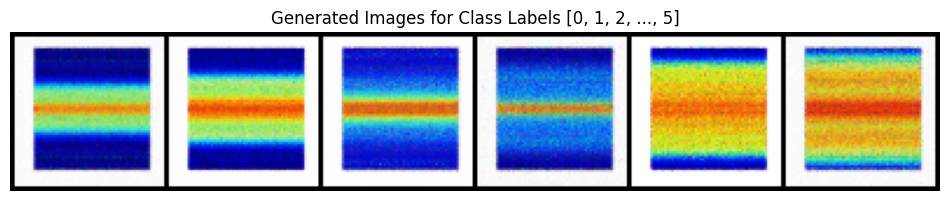

In [25]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def test_generator(generator, num_classes, latent_dim, device):
    # Set the generator to evaluation mode
    generator.eval()
    
    # Generate random noise and class labels
    z = torch.randn(num_classes, latent_dim).to(device)  # Generate noise
    labels = torch.arange(num_classes).to(device)  # Class labels [0, 1, 2, ..., num_classes-1]
    
    # Move the generator to the specified device (if it's not already there)
    generator = generator.to(device)
    
    # Debugging: Check the device
    print(f"Generator is on device: {next(generator.parameters()).device}")
    print(f"Noise is on device: {z.device}")
    print(f"Labels are on device: {labels.device}")
    
    # Generate images
    with torch.no_grad():  # No need to compute gradients during testing
        gen_imgs = generator(z, labels)
    
    # Debugging: Print shape of generated images
    print(f"Generated images shape: {gen_imgs.shape}")
    
    # Unnormalize the images from [-1, 1] back to [0, 1] for visualization
    gen_imgs = (gen_imgs + 1) / 2.0
    
    # Create a grid of images and display them
    grid = make_grid(gen_imgs.cpu(), nrow=num_classes, normalize=False)
    
    # Debugging: Check grid shape
    print(f"Grid shape: {grid.shape}")
    
    plt.figure(figsize=(12, 12))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(f"Generated Images for Class Labels [0, 1, 2, ..., {num_classes-1}]")
    plt.axis("off")
    plt.show()

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_generator(generator, num_classes=6, latent_dim=100, device=device)



In [26]:
import torch

def test_discriminator(discriminator, generator, dataloader, num_classes, latent_dim, device):
    # Set the models to evaluation mode
    discriminator = discriminator.to(device)  # Move discriminator to the correct device
    generator = generator.to(device)  # Move generator to the correct device
    
    discriminator.eval()
    generator.eval()

    # Initialize lists to store accuracy for real and fake images
    real_accuracy = 0
    fake_accuracy = 0
    class_accuracy = 0
    total_samples = 0

    with torch.no_grad():
        for imgs, labels in dataloader:
            batch_size = imgs.size(0)
            total_samples += batch_size

            imgs = imgs.to(device)
            labels = labels.to(device)
            real_pred, real_aux = discriminator(imgs)
            real_accuracy += (real_pred > 0.5).float().mean().item()  # Binary classification for real/fake
            class_accuracy += (real_aux.argmax(dim=1) == labels).float().mean().item()  # Class accuracy

            # Fake images
            z = torch.randn(batch_size, latent_dim).to(device)
            gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
            gen_imgs = generator(z, gen_labels)

            fake_pred, fake_aux = discriminator(gen_imgs)
            fake_accuracy += (fake_pred < 0.5).float().mean().item()  # Fake should be classified as 0 (fake)
            class_accuracy += (fake_aux.argmax(dim=1) == gen_labels).float().mean().item()

    # Calculate average accuracies
    real_accuracy /= len(dataloader)
    fake_accuracy /= len(dataloader)
    class_accuracy /= (2 * len(dataloader))  # Since class accuracy is measured for both real and fake

    print(f"Discriminator Real Accuracy: {real_accuracy * 100:.2f}%")
    print(f"Discriminator Fake Accuracy: {fake_accuracy * 100:.2f}%")
    print(f"Discriminator Class Accuracy: {class_accuracy * 100:.2f}%")

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_discriminator(discriminator, generator, dataloader, num_classes=6, latent_dim=100, device=device)



Discriminator Real Accuracy: 37.38%
Discriminator Fake Accuracy: 80.66%
Discriminator Class Accuracy: 90.89%
